# Script to create a figure of an artificially simulated snowpit (several aligned points) </a><a name='top'>

This figure should represent a simulated cross-section of the snowpack, showing the layers' ages, on the area corresponding to the surface of a real snowpit.
    
Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

In [1]:
# TODO warning if the dataset is not made with the same procedure (typically size of pixels kept and indices), conversion from indices <-> coordinates must be revised
# TODO add a warning that last date of dataset is later than snowpit digging date
# TODO explicit the fact that the zero is defined as the min of the summer surface (relative height)
# TODO add a warning about the sliced_data.nc file

In [17]:
# TODO pcolormesh is probably not such a good idea as the layers don't match from one point to another
# TODO add map with position of the three points

## Imports and functions

In [3]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 8, time 0).


In [4]:
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.colors as colors

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to create a new colormap as a truncated version of a previously existing colormap
    Args:
        cmap: previously existing colormap
        minval: float from 0 to 1, start of the new colormap (as a fraction of the previous one)
        maxval: float from 0 to 1, end of the new colormap (as a fraction of the previous one)
        n: int used in the np.linspace, default 100
    Returns:
        new_cmap: the new truncated colormap
    '''
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Define parameters </a><a name='fill-in'>

In [6]:
# Dataset creation

netcdf_files = '/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc'

#Select points of interest from CloudCompare (coordinates in meters)

# Pit 1
# nb_points_in_pit = 10
# x_range = np.linspace(-10.1, -11.61, num=nb_points_in_pit)
# y_range = np.linspace(1.4, -0.25, num=nb_points_in_pit)
# interest_points = [[x_range[i], y_range[i]] for i in range(nb_points_in_pit)]

# Pit 2
nb_points_in_pit = 10
x_range = np.linspace(-8.1, -9.11, nb_points_in_pit)
y_range = np.linspace(-1, 0.74, nb_points_in_pit)
interest_points = [[x_range[i], y_range[i]] for i in range(nb_points_in_pit)]


[Back to top section](#top)

## Create dataset

In [7]:
# Round points to existing coordinates

# x = x//1 + x%1  where x%1 is always positive

interest_points_coords = interest_points
for i in range(len(interest_points_coords)):
    for j in range(2):
        interest_points_coords[i][j] = round(0.05 + 0.1*((interest_points_coords[i][j]-0.05)//0.1) + round((interest_points_coords[i][j]-0.05)%0.1, 1), 2)

# Get extreme points to delimitate the dataset to be used

x_min = min(interest_points_coords[i][0] for i in range(len(interest_points)))
x_max = max(interest_points_coords[i][0] for i in range(len(interest_points)))
y_min = min(interest_points_coords[i][1] for i in range(len(interest_points)))
y_max = max(interest_points_coords[i][1] for i in range(len(interest_points)))


In [8]:
print(interest_points_coords)

[[-8.05, -0.95], [-8.25, -0.85], [-8.35, -0.65], [-8.45, -0.45], [-8.55, -0.25], [-8.65, -0.05], [-8.75, 0.15], [-8.85, 0.35], [-8.95, 0.55], [-9.15, 0.75]]


In [9]:
# Convert coordinates to indices

# x: 201 points, from -19.95 to 0.05, steps of 0.1
# y: 91 points, from 4.55 to -4.45, steps of 0.1

x_inf = round(10*(x_min)+199.5)
x_sup = round(10*(x_max)+199.5)
y_inf = round(-10*(y_min)+45.5)
y_sup = round(-10*(y_max)+45.5)

# Create dataset

all_data_filled = xr.open_mfdataset(netcdf_files, chunks={'x': 20,'y': 20, 'time': 10})

sliced_data = all_data_filled.isel(x=slice(x_inf,x_sup+1), y=slice(y_sup,y_inf+1))
sliced_data.to_netcdf('sliced_data_pit.nc')

## Clean dataset, pre-processing

In [10]:
# Clean dataset

data_set_used = xr.open_dataset('sliced_data_pit.nc')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=9, y_span=9)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['summer_surface']


---> Median filtering in space with a window [9, 9]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2021-12-06 to 2021-12-07


In [11]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

## Simulate snowpack at each point

In [12]:
# Define structures to store data for plotting

depth_data = np.zeros((len(interest_points), max_nb_of_layers))
age_data = np.zeros((len(interest_points), max_nb_of_layers))

offset_at_each_point = np.zeros((len(interest_points)))   # snow height at the first accumulation
last_scan_heights = []    # in meters above the min summer surface
summer_scan_heights = []    # in meters above the min summer surface

In [13]:
# Loop on each interest point and run simulations

for point_nb in range(len(interest_points)):
    
    # Convert coordinates to indices

    x_coord = interest_points[point_nb][0]
    y_coord = interest_points[point_nb][1]

    x_sel = round(10*(x_coord-data_set_used.x.values[0]))
    y_sel = round(-10*(y_coord-data_set_used.y.values[0]))

    # Define structures to store snow parameters

    ro_layer = np.zeros((max_nb_of_layers, 1))
    t_old = np.zeros((max_nb_of_layers, 1))
    dy_snow = np.zeros((max_nb_of_layers, 1))
    gamma = np.zeros((max_nb_of_layers, 1))
    melt_flag = np.zeros((max_nb_of_layers, 1))
    age_layers = np.zeros((max_nb_of_layers, 1))
    
    # Get timing of events

    results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
    start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

    # Convert end times into more manageable orders of magnitude

    end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
    end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
    end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    # Simulate the snowpack

    snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve, erode_several_layers=simul_erode_several_layers)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]

    # Save data

    depth_data[point_nb] = depth_evolution[-1]
    age_data[point_nb] = [age_layers[i][0] for i in range(len(age_layers))]
    
    offset_at_each_point[point_nb] = float(data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_accumulation[0]))
    last_scan_heights.append(float(data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').isel(time=-1)) - float(data_set_used['summer_surface'].min()))
    summer_scan_heights.append(float(data_set_used['summer_surface'].isel(x=x_sel, y=y_sel)) - float(data_set_used['summer_surface'].min()))


## Plot data

In [14]:
# Transpose data and convert to lists for correct plotting

depth_data = list(depth_data.T)
age_data = list(age_data.T)

for i in range(len(age_data)):
    age_data[i] = list(age_data[i])
    
for i in range(len(depth_data)):
    depth_data[i] = list(depth_data[i])

# Format indications:

# depth_data = [[depth of first layer at each point],
#        [depth of 2nd layer at each point], [...], ...]

# age_data = [[age of first layer at each point],
#             [age of 2nd layer at each point], [...], ...]

In [15]:
# Define figure size to have a quasi proportionally correct geometry

x_1 = x_range[0]
y_1 = x_range[0]
x_2 = x_range[-1]
y_2 = x_range[-1]

distance_btwn_extreme_pts = math.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)
distance_btwn_x_pts = distance_btwn_extreme_pts / (len(depth_data[0])-1)
zoom_factor = 5

figure_height = 1.9
figure_width = distance_btwn_extreme_pts

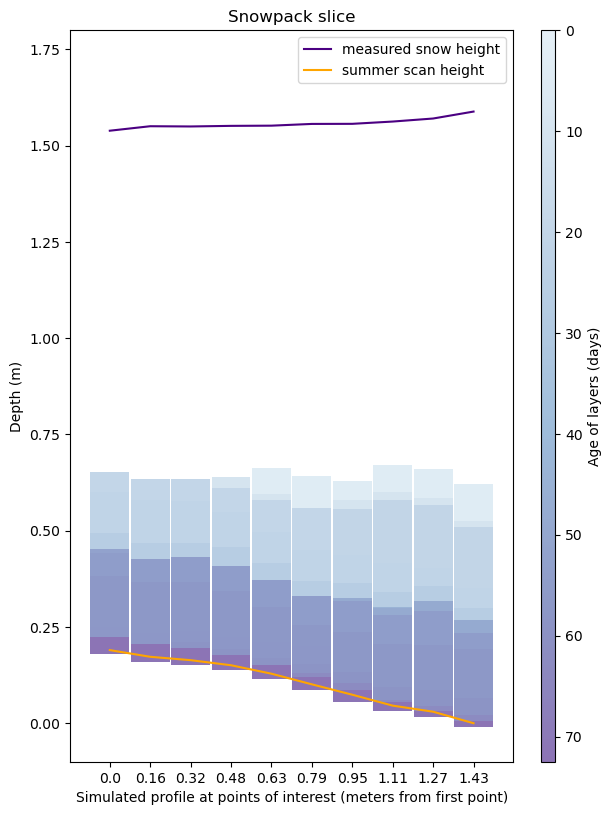

In [16]:
# Plot the simulated snowpit

plt.figure(figsize=(figure_width*zoom_factor, figure_height*zoom_factor))

# Discretization of the age range
nb_age_slices = 125
age_slice_size = round((max(max(age_data))+1) / nb_age_slices)

# Get some pastel shades for the colors
cmap = plt.get_cmap('BuPu')
new_cmap = truncate_colormap(cmap, 0.1, 0.6)
colors_list = new_cmap(np.linspace(0, 1, nb_age_slices))

# Initialization of the color values used when plotting layers
color_to_use = []

# Visual parameters
index = np.arange(len(depth_data[0])) * distance_btwn_x_pts + 0.3 * distance_btwn_x_pts
bar_width = 0.96 * distance_btwn_x_pts

# Initialize the vertical-offset for the stacked bar chart
y_offset = np.array(summer_scan_heights) + offset_at_each_point

# Plot bars with colors corresponding to age
for row in range(len(depth_data)):
    for i in range(len(depth_data[0])):
        color_to_use.append(colors_list[min(int(age_data[row][i]//age_slice_size), len(colors_list)-1)])
    plt.bar(index, depth_data[row], bar_width, bottom=y_offset, color=color_to_use)
    y_offset = y_offset + depth_data[row]
    color_to_use = []

# Plot measured total snowheight and summer surface
plt.plot(index, last_scan_heights, label='measured snow height', c='indigo')
plt.plot(index, summer_scan_heights, label='summer scan height', c='orange')
    
# Plot's axes and colorbar
plt.ylabel("Depth (m)")
plt.ylim([-0.1, -0.1+figure_height])
plt.xlabel("Simulated profile at points of interest (meters from first point)")
xticks_labels = [str(round(i, 2)) for i in np.arange(len(depth_data[0])) * distance_btwn_x_pts]
plt.xticks(np.arange(len(depth_data[0])) * distance_btwn_x_pts + 0.3 * distance_btwn_x_pts, xticks_labels)
plt.title('Snowpack slice')

max_age = (max(max(age_data))+1) / 3600 / 24
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=max_age), cmap=new_cmap), orientation='vertical', label='Age of layers (days)', aspect=50)
cbar.ax.invert_yaxis()

plt.legend()

plt.show()
